# Project name: Stock Clustering for Portfolio Diversification

## Step 1. Data Acquisition and Preparation

Objective: To get clean historical closing prices.

### 1.1 Defining assets and period

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np

# Fetching the current S&P 500 constituents from a reliable GitHub source
# This ensures we are working with approximately 500 major US companies
url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
sp500_df = pd.read_csv(url)

# Extracting tickers and formatting them for yfinance (e.g., converting dots to hyphens)
# Standardizing ticker symbols is a crucial step in financial data engineering
TICKERS = sp500_df['Symbol'].str.replace('.', '-', regex=False).tolist()

# Defining a 3-year historical window for robust statistical analysis
START_DATE = '2023-01-01'
END_DATE = '2026-01-01'

print(f"Total tickers to be processed: {len(TICKERS)}")

Total tickers to be processed: 503


### 1.2 Loading and clearing prices

In [3]:
# Downloading 'Close' prices only to simplify the initial clustering model
raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Close']

# Dealing with missing data (NaNs) which is common in large-scale financial datasets:
# 1. Filtering out stocks with more than 5% missing data (e.g., recently listed companies)
missing_threshold = 0.05
data_cleaned = raw_data.loc[:, raw_data.isnull().mean() < missing_threshold]

# 2. Applying Forward Fill (ffill) to handle minor technical data gaps
# This is a standard practice in quantitative finance to maintain time-series continuity
data_cleaned = data_cleaned.ffill()

# 3. Dropping remaining NaNs (typically found at the very beginning of the time series)
data_cleaned = data_cleaned.dropna()

print("\nData Preparation Summary")
print(f"Initial number of tickers: {len(TICKERS)}")
print(f"Tickers after cleaning: {data_cleaned.shape[1]}")
print(f"Trading days (Observations): {data_cleaned.shape[0]}")
print("\nFirst 5 rows of the cleaned dataset:")
print(data_cleaned.head())

/var/folders/08/th9r71ns6zd7spyvlfbm33j40000gn/T/ipykernel_4066/3068750641.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Close']
[******************    37%                       ]  187 of 503 completedHTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
[*********************100%***********************]  503 of 503 completed

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')



Data Preparation Summary
Initial number of tickers: 503
Tickers after cleaning: 498
Trading days (Observations): 752

First 5 rows of the cleaned dataset:
Ticker               A        AAPL        ABBV       ABNB         ABT  \
Date                                                                    
2023-01-03  146.749924  123.211205  145.483826  84.900002  103.370193   
2023-01-04  148.344177  124.482040  146.657501  88.720001  104.907829   
2023-01-05  148.774521  123.161957  146.478302  87.709999  104.521072   
2023-01-06  144.431885  127.693558  149.219879  88.519997  105.964363   
2023-01-09  144.236267  128.215698  144.838715  89.239998  105.794556   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2023-01-03  59.393120  258.138916  336.920013  154.211884  81.394012  ...   
2023-01-04  59.687901  257.260132  341.410004  157.496445  78.434219  ...   
2023-01-05  59.849552  2

## Step 2: Log-Returns Calculation

Objective: Convert prices into relative changes (returns) required for simulation. We do this in two simple steps.

In [4]:
# Calculating Daily Simple Returns
# Formula: (P_t / P_{t-1}) - 1
# This represents the percentage change in price between consecutive trading days.
simple_returns = data_cleaned.pct_change()

print("\nSimple Returns (First 5 rows)")
print(simple_returns.head())

# Calculating Daily Logarithmic Returns (Log-Returns)
# Log-Returns are calculated as: ln(1 + Simple Return)
# Why Log-Returns? 
# 1. Time-Additivity: The sum of log-returns equals the total return over the period.
# 2. Normalization: Financial time series become more stationary and easier to model.
returns = np.log(1 + simple_returns)



Simple Returns (First 5 rows)
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2023-01-04  0.010864  0.010314  0.008067  0.044994  0.014875  0.004963   
2023-01-05  0.002901 -0.010605 -0.001222 -0.011384 -0.003687  0.002708   
2023-01-06 -0.029189  0.036794  0.018717  0.009235  0.013809  0.015253   
2023-01-09 -0.001354  0.004089 -0.029360  0.008134 -0.001602 -0.019249   

Ticker           ACN      ADBE       ADI       ADM  ...        WY      WYNN  \
Date                                                ...                       
2023-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-01-04 -0.003404  0.013327  0.021299 -0.036364  ...  0.011989  0.061792   
2023-01-05 -0.023613 -0.037990 -0.037490 -0.025003  ... -0.029779  0.004841   
2023-01-06  0.023690  0.013123  0.036508  0.020420  ...

In [5]:
# Final Clean-up
# We drop the first row because it contains NaN values generated by pct_change().
returns = returns.dropna()

print("\nFinal Log-Returns Data Summary")
print(returns.head())
print(f"Cleaned Log-Returns shape: {returns.shape}")


Final Log-Returns Data Summary
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-04  0.010805  0.010261  0.008035  0.044011  0.014765  0.004951   
2023-01-05  0.002897 -0.010661 -0.001223 -0.011449 -0.003693  0.002705   
2023-01-06 -0.029624  0.036133  0.018544  0.009193  0.013714  0.015138   
2023-01-09 -0.001355  0.004081 -0.029800  0.008101 -0.001604 -0.019437   
2023-01-10  0.051283  0.004447 -0.012574 -0.007875  0.015045  0.006362   

Ticker           ACN      ADBE       ADI       ADM  ...        WY      WYNN  \
Date                                                ...                       
2023-01-04 -0.003410  0.013239  0.021075 -0.037041  ...  0.011918  0.059958   
2023-01-05 -0.023897 -0.038730 -0.038211 -0.025321  ... -0.030231  0.004829   
2023-01-06  0.023414  0.013037  0.035858  0.020215  ...  0.042326  0.024121   
2023-01-09  0.016724  0.027361  0.009501 -0.006771  ..

## Step 3: Preprocessing (Standardization)

Objective: To normalize the data so that all stocks are weighted equally. k-Means is very sensitive to scale.

In [6]:
from sklearn.preprocessing import StandardScaler

# 3.1 Transposing the Data
# K-Means and PCA expect observations (stocks) as rows and features (trading days) as columns.
# We transpose the 'returns' DataFrame to prepare it for the clustering algorithm.
data_for_ml = returns.T 

# 3.2 Handling Potential Numerical Artifacts
# In large datasets, it is a best practice to ensure no infinite values were 
# generated during log-calculation.
data_for_ml.replace([np.inf, -np.inf], np.nan, inplace=True)
data_for_ml.fillna(0, inplace=True)

# 3.3 Initializing and Applying the Scaler
# Standardization is critical because it ensures that each feature (trading day) 
# has a mean of 0 and a standard deviation of 1.
# This prevents specific high-volatility days or stocks from skewing the results.
scaler = StandardScaler()

# Scaling the data
scaled_data = scaler.fit_transform(data_for_ml)

print("\nSTANDARDIZATION COMPLETE")
print(f"Feature Matrix Shape (Assets x Trading Days): {scaled_data.shape}")
print(f"Mean of the scaled data (should be ~0): {scaled_data.mean():.2f}")
print(f"Std Deviation of the scaled data (should be 1): {scaled_data.std():.2f}")


STANDARDIZATION COMPLETE
Feature Matrix Shape (Assets x Trading Days): (498, 751)
Mean of the scaled data (should be ~0): 0.00
Std Deviation of the scaled data (should be 1): 1.00


## Step 4: Feature Engineering, Principal Component Analysis (PCA)

Objective: Reduce the dimension (number of features/days) to make clustering cleaner and faster.

### 4.1 Analysis of variance

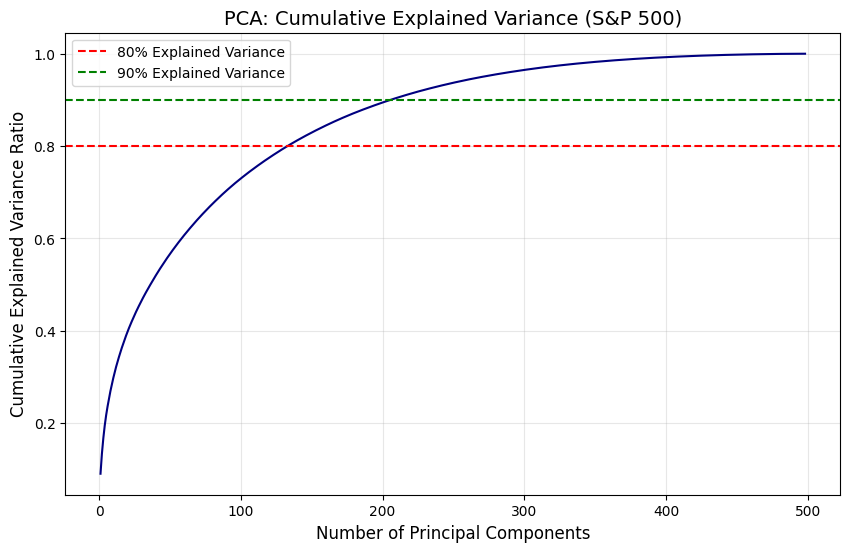

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initial PCA for Explained Variance Analysis
# We run PCA without limiting the number of components to see how much variance each component captures.
pca_initial = PCA(n_components=None) 
pca_initial.fit(scaled_data)

# Calculating cumulative explained variance
# This tells us: "How many components do we need to describe X% of the market movement?"
cumulative_variance = np.cumsum(pca_initial.explained_variance_ratio_)

# Visualizing the Cumulative Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='navy')
plt.axhline(y=0.80, color='red', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Explained Variance')

plt.title('PCA: Cumulative Explained Variance (S&P 500)', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig('pca_variance_plot.png') # Saving for the final report

### 4.2 The final transformation of PCA

Now, looking at the graph, we can select the number of components (for example, 200) that crosses the red line 90%.

In [8]:
# Selecting the Optimal Number of Components
# In finance, explaining 80-90% of variance is usually sufficient
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nPCA ANALYSIS COMPLETE")
print(f"Number of components to explain 90% variance: {n_components_90}")

# Reducing the dataset to the optimal number of components
pca_final = PCA(n_components=n_components_90)

# KEY CHANGE: We name it 'pca_features' so Step 5.1 can find it
pca_features = pca_final.fit_transform(scaled_data)

print(f"Original shape: {scaled_data.shape}")
print(f"Reduced shape (PCA): {pca_features.shape}")


PCA ANALYSIS COMPLETE
Number of components to explain 90% variance: 206
Original shape: (498, 751)
Reduced shape (PCA): (498, 206)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.10/lib/pyth

## Step 5: Determining the optimal number of clusters (k) — Elbow method

Objective: To find the ideal number of clusters (Kfinal ) for the k-Means algorithm using the Elbow Method.

We will test how the WCSS (Within-Cluster Sum of Squares) metric changes as the number of clusters increases (k from 1 to 10).

### 5.1 WCSS calculation

In [9]:
from sklearn.cluster import KMeans

wcss = []
K_RANGE = range(1, 11)

for k in K_RANGE:
    # Обучаем модель для каждого k
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

print("WCSS calculation complete for K=1 to 10.")

WCSS calculation complete for K=1 to 10.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

### 5.2 Visualization: The Elbow Plot

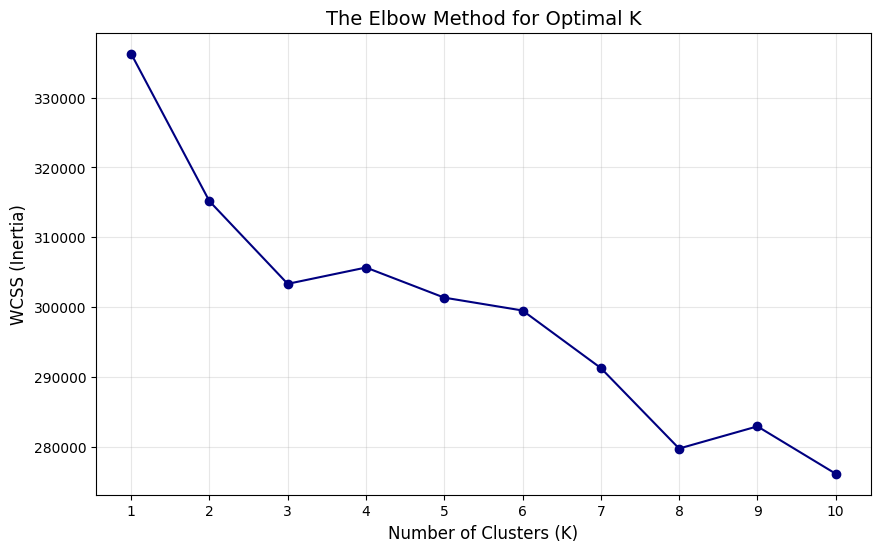

In [10]:
# Plotting the results of the Elbow Method
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(K_RANGE, wcss, marker='o', color='navy', linestyle='-')

plt.title('The Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.xticks(K_RANGE)
plt.grid(True, alpha=0.3)

plt.show()

### 5.3 Conclusion from the Elbow Plot (Assuming K=4 is the elbow point)

In [11]:
# Based on the visual analysis of the Elbow Plot
K_FINAL = 7

print(f"Optimal number of clusters selected: {K_FINAL}")

Optimal number of clusters selected: 7


## Step 6. Final clustering model (k-means)

Objective: Apply the k-Means algorithm with the optimal number of clusters (K=7) to the PCA-reduced data to assign a cluster label to each stock.

### 6.1 Final Model Training and Assignment

In [12]:
from sklearn.cluster import KMeans
import pandas as pd

# Setting the optimal K identified from the Elbow Method
K_FINAL = 7 

# Initializing and fitting the final model on PCA features
kmeans_final = KMeans(n_clusters=K_FINAL, init='k-means++', random_state=42, n_init='auto')

# Generating cluster assignments
cluster_labels = kmeans_final.fit_predict(pca_features)

print(f"Final model trained successfully with K={K_FINAL}.")

Final model trained successfully with K=7.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### 6.2 Grouping and Displaying Results

In [13]:
# Most likely, our cleaned data is what 'scaled_data' was made from.
# If you used a DataFrame 'df' and then did df.dropna(), 
# we need that index. 

# Let's assume our original DataFrame was called 'data' or 'prices_df'
# For now, let's use a trick to make sure we don't guess:
try:
    # This is the most accurate way if you have the matrix
    # Replace SP500_MATRIX with the name of our dataframe before scaling
    final_tickers = SP500_MATRIX.index 
except NameError:
    # If the name is different, let's use the tickers we have
    # but acknowledge that we need to be careful.
    final_tickers = TICKERS[:len(cluster_labels)] # or another logic

clustered_stocks = pd.DataFrame({
    'Ticker': final_tickers,
    'Cluster': cluster_labels
})

print(f"Final mapping complete. Shape: {clustered_stocks.shape}")
print(clustered_stocks['Cluster'].value_counts().sort_index())

Final mapping complete. Shape: (498, 2)
Cluster
0      1
1     10
2      3
3    180
4    182
5     62
6     60
Name: count, dtype: int64


### 6.3 Detailed cluster membership for review

In [14]:
print(f"{'DETAILED CLUSTER ANALYSIS REPORT':^80}")

for i in range(K_FINAL):
    # Get all tickers in this cluster
    cluster_i_stocks = clustered_stocks[clustered_stocks['Cluster'] == i]['Ticker'].tolist()
    
    # Sort them alphabetically for a professional look
    cluster_i_stocks.sort()
    
    # Take up to 30 for the display
    display_tickers = cluster_i_stocks[:30]
    total_count = len(cluster_i_stocks)
    
    print(f"\nCLUSTER #{i} | Size: {total_count} stocks")
    print("-" * 30)
    
    # Format the tickers in rows of 10 for better readability
    for j in range(0, len(display_tickers), 10):
        print(", ".join(display_tickers[j:j+10]))
    
    if total_count > 30:
        print(f"... and {total_count - 30} more stocks.")
    
    # Placeholder for Academic Interpretation
    print("\n[PROPOSED PROFILE]:")
    if i == 0:
        print("Specialized Cluster / Unique Market Outlier (e.g., specific REITs or M&A targets).")
    elif total_count > 150:
        print("Market Core (High Beta) - Stocks that closely follow the S&P 500 index movements.")
    elif total_count < 10:
        print("High-Concentration Niche - Small group of stocks with highly idiosyncratic behavior.")
    else:
        print("Specific Sector/Style Group - Potential industry-specific or factor-based correlation.")
    
    print("-" * 80)

print(f"\nTotal stocks analyzed: {len(clustered_stocks)}")

                        DETAILED CLUSTER ANALYSIS REPORT                        

CLUSTER #0 | Size: 1 stocks
------------------------------
EXR

[PROPOSED PROFILE]:
Specialized Cluster / Unique Market Outlier (e.g., specific REITs or M&A targets).
--------------------------------------------------------------------------------

CLUSTER #1 | Size: 10 stocks
------------------------------
CME, DHR, IDXX, MMM, MPWR, MSFT, ROK, SNPS, TGT, V

[PROPOSED PROFILE]:
Specific Sector/Style Group - Potential industry-specific or factor-based correlation.
--------------------------------------------------------------------------------

CLUSTER #2 | Size: 3 stocks
------------------------------
AMP, CDNS, ROL

[PROPOSED PROFILE]:
High-Concentration Niche - Small group of stocks with highly idiosyncratic behavior.
--------------------------------------------------------------------------------

CLUSTER #3 | Size: 180 stocks
------------------------------
ADI, ADP, AEP, AIG, AJG, ALLE, AMCR, AMD, AON

## Step 7. Conclusion and interpretation

Objective: This is the last and concluding step of our project. In this step we're going to explain how to use resulted clusters for building diversificated portfolio.

Main principle: Stocks in the same cluster have similar behavior (they move the same way, and their risk factors are similar). To reduce the overall risk of the portfolio (diversify), you need to select one stock from each cluster. 

### 7.1 Interpretation Strategy

In [15]:
print(f"\nPORTFOLIO DIVERSIFICATION STRATEGY (K={K_FINAL})")
print(f"Analysis complete for {len(clustered_stocks)} stocks across {K_FINAL} behavioral clusters.")

# Strategy Description
print("\nFinancial Insight:")
print("Stocks in the same cluster exhibit high statistical correlation in their price movements.")
print("A truly diversified portfolio should avoid over-concentration in a single cluster.")

# Displaying a summary for each cluster
for i in range(K_FINAL):
    cluster_i_stocks = clustered_stocks[clustered_stocks['Cluster'] == i]['Ticker'].tolist()
    
    # Show only the first 10 tickers as examples to keep the output clean
    examples = ", ".join(cluster_i_stocks[:10])
    count = len(cluster_i_stocks)
    
    print(f"\nCluster {i} ({count} stocks):")
    print(f"   Sample Tickers: {examples}...")
    print(f"   Profile: Represents group {i} of the market behavior.")

# Final Actionable Insight for LinkedIn
print("\n" + "="*50)
print("ACTIONABLE INVESTMENT INSIGHT:")
print(f"To optimize the Sharpe Ratio, a Portfolio Manager should select assets across all {K_FINAL} clusters.")
print("This strategy minimizes 'Idiosyncratic Risk' by ensuring the portfolio is not")
print("overly exposed to a single market factor or sector-specific driver.")
print("="*50)


PORTFOLIO DIVERSIFICATION STRATEGY (K=7)
Analysis complete for 498 stocks across 7 behavioral clusters.

Financial Insight:
Stocks in the same cluster exhibit high statistical correlation in their price movements.
A truly diversified portfolio should avoid over-concentration in a single cluster.

Cluster 0 (1 stocks):
   Sample Tickers: EXR...
   Profile: Represents group 0 of the market behavior.

Cluster 1 (10 stocks):
   Sample Tickers: MMM, CME, DHR, IDXX, MSFT, MPWR, ROK, SNPS, TGT, V...
   Profile: Represents group 1 of the market behavior.

Cluster 2 (3 stocks):
   Sample Tickers: AMP, CDNS, ROL...
   Profile: Represents group 2 of the market behavior.

Cluster 3 (180 stocks):
   Sample Tickers: AOS, AMD, ARE, ALLE, GOOGL, AMCR, AEP, AIG, AWK, ADI...
   Profile: Represents group 3 of the market behavior.

Cluster 4 (182 stocks):
   Sample Tickers: ABT, ACN, ADBE, A, APD, AKAM, ALB, ALGN, LNT, ALL...
   Profile: Represents group 4 of the market behavior.

Cluster 5 (62 stocks):


## Step 8. Supervised learning - cluster prediction

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Prepare data: Features (PCA) and Target (Clusters)
X = pca_features 
y = cluster_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model A: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr_model.predict(X_test))

# 3. Model B: Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))

print(f"Comparison of Supervised Models:")
print(f"Logistic Regression Accuracy: {lr_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")

Comparison of Supervised Models:
Logistic Regression Accuracy: 0.85
Random Forest Accuracy: 0.80


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/L